# Project: Expansion of the Universe

500


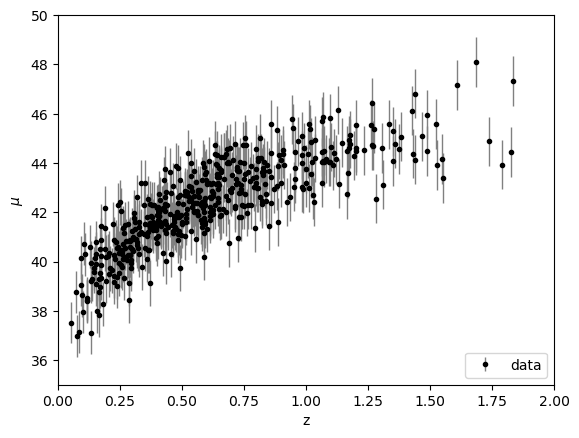

In [1]:
from pylab import plt
import numpy as np

z_sample, mu_sample, dmu = np.loadtxt('data/supernovae.txt').T

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

print(len(z_sample))

### Evaluate $\mu$ predictions

The task is to measure the properties of the universe $H_0$, $\Omega_{\text{DM}}$ and $\Omega _\Lambda$ to achieve the best estimation for $\mu$ given $z$. 

The distance modulus $\mu$ is:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_{\rm DM} (1+z')^3+\Omega_\Lambda}} \right)$$

We have a dataset with three values per observation: $z$, the redshift; $\mu$, the distance from $m-M$; $d\mu$, the errors.

We first start with a bayesian approach, leveraging MCMC and Nested Sampling to find an approximation of the three properties. Then, we introduce a non-bayesian approach based on neural networks.

## Part 1: Bayesian Approach - MCMC and Nested Sampling

### First Case: Assume an one-parameter model

We start with a simpler model.

The assumptions are:

1. $\Omega_\Lambda$ is zero, i.e. dark energy does NOT exist.

2. The geometry of the universe is flat, $\Omega_{\text{DM}}=1$

The task is to sample the posterior distribution of $H_0$. 

For priors, here's what we found by looking for information on the web:

- Hubble constant changes over time, originally was set at 500km/s/Mpc.
    - Now it is estimated to be around 65 to 75km/s/Mpc. 

- We know that $\Omega_{\rm OM}+\Omega_{\rm ph}+\Omega_{\rm DM}+\Omega_{\rm \Lambda}=1$

Now, since $\Omega_{\text{DM}}=1$ and $\Omega_\Lambda=0$, the integral part becomes: 

$$\int^z_0 \frac{dz'}{\sqrt{(1+z')^3}} = 2 \left ( 1 - \frac {1} {\sqrt{1+z}}\right)$$

$$\mu = 5 \log \left(\left( \frac{c/H_0} {10 {\rm pc}}(1+z)\right)2 \left ( 1 - \frac {1} {\sqrt{1+z}}\right)\right)$$

#### MCMC

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [H0]


Output()

Sampling 2 chains for 3_000 tune and 10_000 draw iterations (6_000 + 20_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


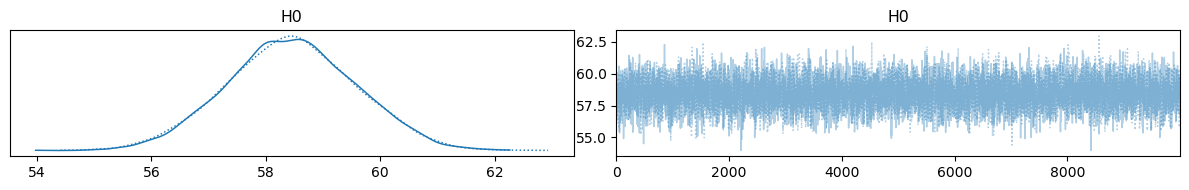

In [2]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from scipy.constants import c, parsec

H0_conv_factor = 3.24078e-20
z_sample, mu_sample, dmu_sample = np.loadtxt('data/supernovae.txt').T

def mu_mod(z, H0_s, numpy=False):
    if numpy:
        return 5 * np.log10(((c / H0_s) / (10 * parsec)) * (1 + z) * 2 * (1 - 1 / np.sqrt(1 + z)))
    return 5 * pt.log10(((c / H0_s) / (10 * parsec)) * (1 + z) * 2 * (1 - 1 / pt.sqrt(1 + z)))

with pm.Model() as model:
    # Data
    z = pm.Data('z', z_sample)
    mu = pm.Data('mu', mu_sample)
    dmu = pm.Data('dmu', dmu_sample)

    # Priors
    H0 = pm.Normal('H0', mu=70, sigma=10)
    H0_s = H0 * H0_conv_factor
    Omega_dm = pt.constant(1.0)
    Omega_lam = pt.constant(0.0)

    # Model
    mu_model = mu_mod(z, H0_s)

    # Likelihood
    mu_obs = pm.Normal('mu_obs', mu=mu_model, sigma=dmu, observed=mu)

    # Inference
    trace1 = pm.sample(10000, tune=3000, cores=1, target_accept=0.95, return_inferencedata=True)


az.plot_trace(trace1, var_names=["H0"])
plt.tight_layout()
plt.show()



In [3]:
az.summary(trace1, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H0,58.44,1.13,56.3,60.53,0.01,0.01,7091.86,7503.69,1.0


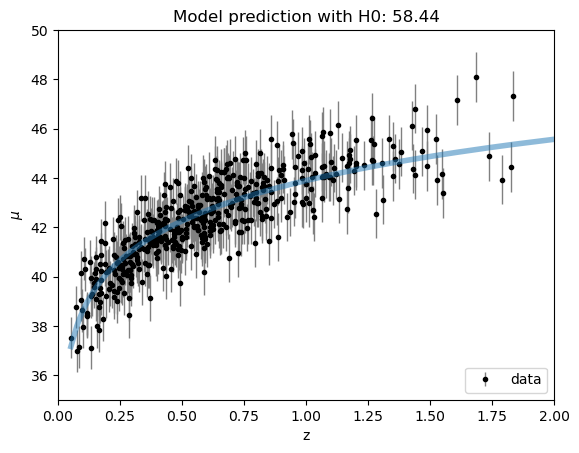

In [4]:
plt.errorbar(z_sample, mu_sample, dmu_sample, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

z_ordered = np.array(sorted(z_sample))

plt.title(f'Model prediction with H0: {trace1.posterior.H0.mean().values.flatten()[0]:.2f}')
plt.plot(z_ordered, mu_mod(z_ordered, trace1.posterior.H0.mean().values.flatten()[0] * 3.24078e-20, numpy=True), zorder=3, linewidth=4, alpha=0.5)


#### Nested Sampling

`PyMC` has the option of doing nested sampling using dynesty, directly in the `trace` arguments. 

Since we really like the plots dynesty offers, and because it will help us a lot when computing Bayes factors, we will rebuild our model outside `PyMC`.

In [5]:
import dynesty
import dynesty.plotting as dyplot

def dyn_model(z, H0_s):
    return 5 * np.log10(((c / H0_s) / (10 * parsec)) * (1 + z) * 2 * (1 - 1 / np.sqrt(1 + z)))

def dyn_model_loglikelihood(theta, z, mu, dmu):
    H0_s = theta[0] * H0_conv_factor

    mu_model = dyn_model(z, H0_s)
    return -0.5 * np.sum(((mu - mu_model) / dmu) ** 2)

def dyn_prior_transform(theta):
    # u is a unit cube, whose each dimension is in [0, 1]
    return np.array([theta[0] * 20 + 55]) # H0 in [55, 75]

sampler = dynesty.NestedSampler(dyn_model_loglikelihood, dyn_prior_transform, ndim=1, logl_args=(z_sample, mu_sample, dmu_sample))
sampler.run_nested()
sresults = sampler.results

1474it [00:00, 4209.53it/s, +500 | bound: 0 | nc: 1 | ncall: 8824 | eff(%): 23.715 | loglstar:   -inf < -236.968 <    inf | logz: -239.012 +/-  0.031 | dlogz:  0.001 >  0.509]


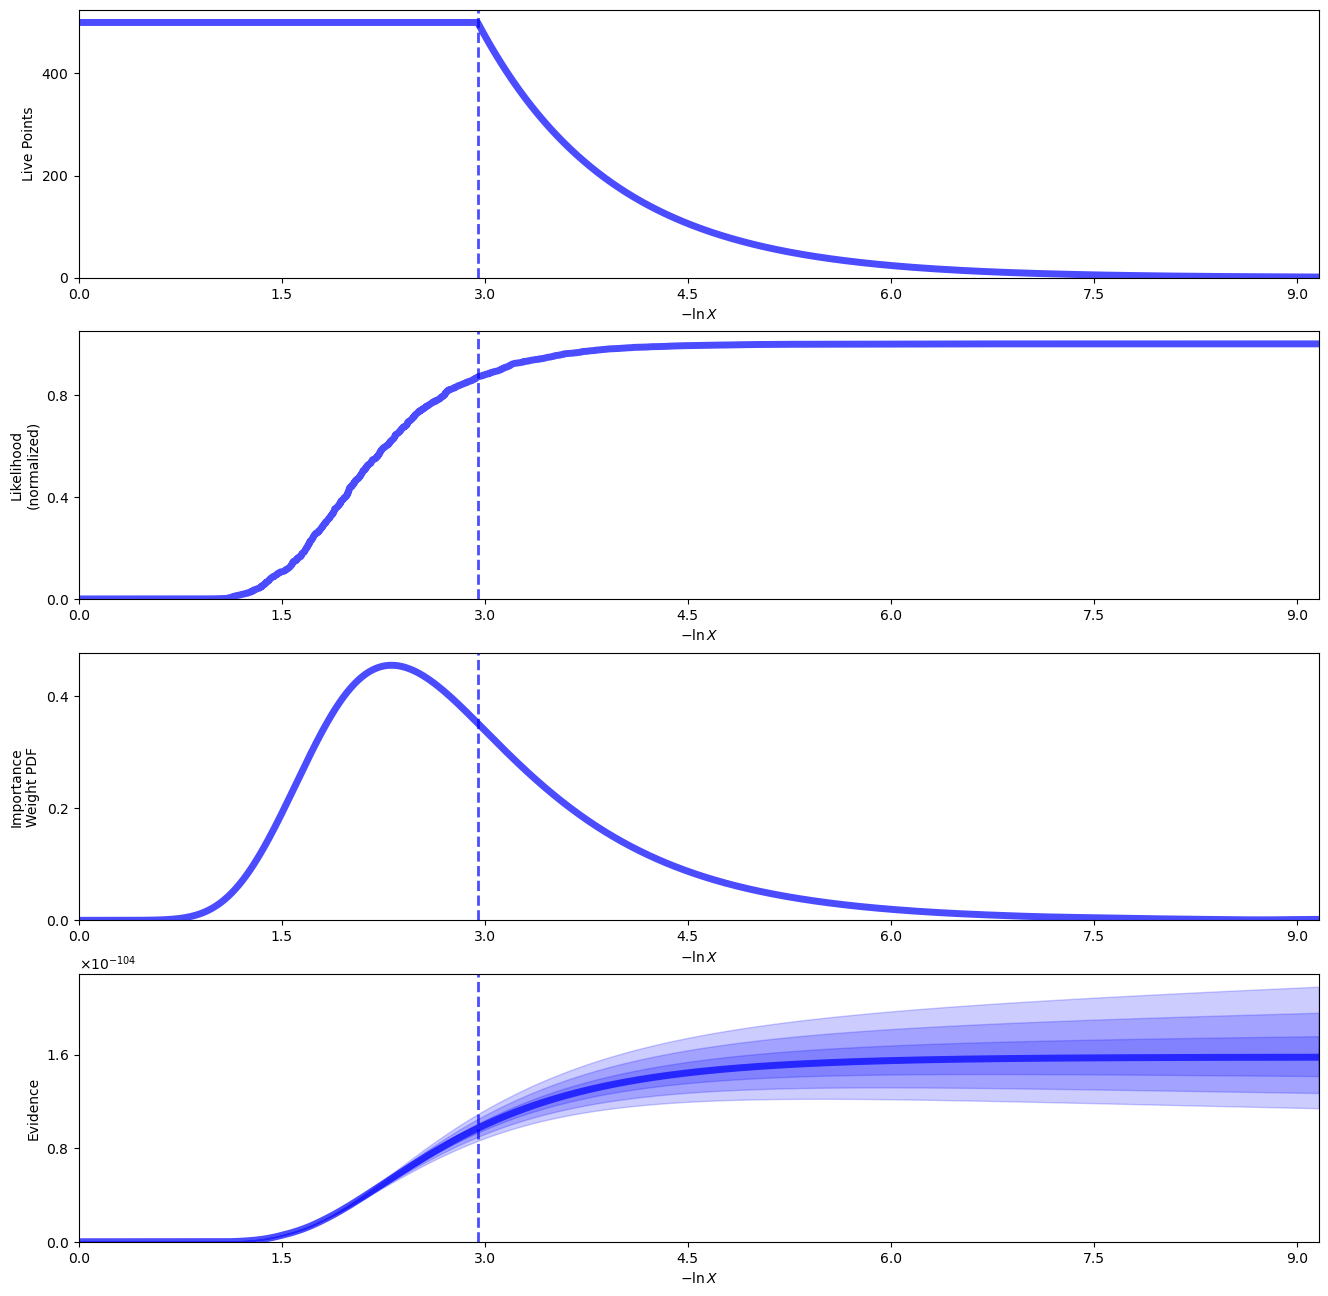

In [6]:
sresults_log_evidence_1d = sresults.logz[-1]
sresults_uncertainty_logz_1d = sresults.logzerr[-1]
rfig, raxes = dyplot.runplot(sresults)

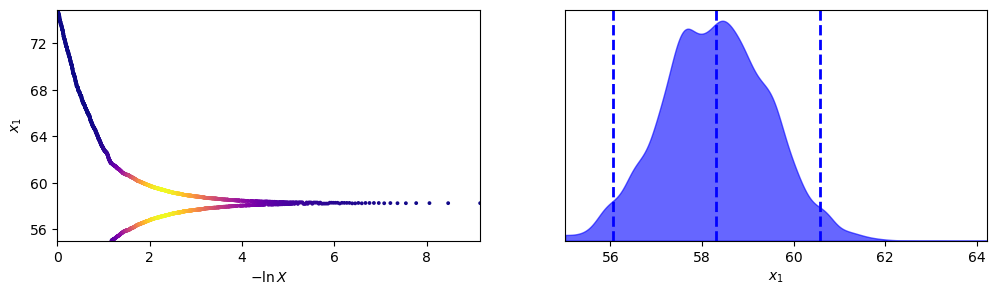

In [7]:
tfig, taxes = dyplot.traceplot(sresults)

In [8]:
samples = sresults.samples
weights = np.exp(sresults.logwt - sresults.logz[-1])

mean = np.average(samples, weights=weights, axis=0)
std = np.sqrt(np.average((samples - mean)**2, weights=weights, axis=0))

print(f'Mean H0: {mean[0]:.2f} ± {std[0]:.2f}')

Mean H0: 58.30 ± 1.14


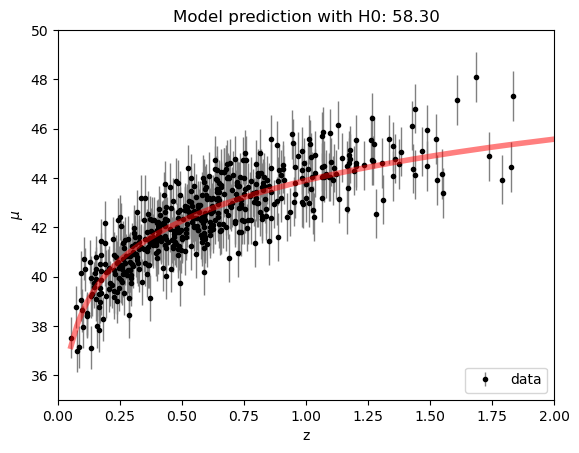

In [9]:
plt.errorbar(z_sample, mu_sample, dmu_sample, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

z_ordered = np.array(sorted(z_sample))

plt.title(f'Model prediction with H0: {mean[0]:.2f}')
plt.plot(z_ordered, mu_mod(z_ordered, mean[0] * 3.24078e-20, numpy=True), 'r', zorder=3, linewidth=4, alpha=0.5)

### Second Case: Two-parameter model $(H_0, \Omega_\text{DM})$

Now we want to find the posterior distribution for $H_0$ and $\Omega_\text{DM}$. We also impose $\Omega_\text{DM} + \Omega_\Lambda=1$.

In this case, we must take into account the whole expression of $\mu$:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_{\rm DM} (1+z')^3+\Omega_\Lambda}} \right)$$

But that's a problem. `PyMC` does not support direct numerical integration through `scipy.integrate.quad`. 

A solution with `PyMC`'s built-in ODE solver was attempted, but the lack of documentation and complexity makes it unfeasable compared to switching to another library like `emcee`.

Thus, for the remainder of the project, `emcee` will be the library used for MCMC.

#### MCMC

In [10]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm, uniform
from scipy.integrate import quad
from scipy.constants import c, parsec

H0_conv_factor = 3.24078e-20
z_sample, mu_sample, dmu_sample = np.loadtxt('data/supernovae.txt').T

# Define prior distributions
H0_prior = norm(loc=70, scale=10)
Omega_dm_prior = uniform()

# Define model
def model(z, H0, Omega_dm):
    H0_s = H0 * H0_conv_factor

    def integrand(x, Omega_dm):
        return 1 / np.sqrt(Omega_dm * (1 + x) ** 3 + (1 - Omega_dm))
    
    vec_integral = np.vectorize(lambda z_val: quad(integrand, 0, z_val, args=(Omega_dm,))[0])
    integral_result = vec_integral(z)
    return 5 * np.log10(((c / H0_s) / (10 * parsec)) * (1 + z) * integral_result)

def loglikelihood(z, mu, sigma):
    return -0.5 * np.sum(((z - mu) / sigma) ** 2 + np.log(2 * np.pi * sigma**2))

def logprior(theta):
    H0, Omega_dm = theta
    
    log_H0 = H0_prior.logpdf(H0)
    log_Omega_dm = Omega_dm_prior.logpdf(Omega_dm)

    return log_H0 + log_Omega_dm

def logposterior(theta, z, mu, dmu):
    if not np.isfinite(logprior(theta)):
        return -np.inf
    return logprior(theta) + loglikelihood(model(z, *theta), mu, dmu)


In [11]:
ndim = 2
nwalkers = 10
nsteps = 3000
burn = 500
initial_guesses = np.column_stack([
    np.random.normal(70, 0.5, size=nwalkers),
    np.random.uniform(0, 1, size=nwalkers)
])

sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=[z_sample, mu_sample, dmu_sample])
sampler.run_mcmc(initial_guesses, nsteps, progress=True)

emcee_trace = sampler.chain[:, burn:, :].reshape(-1, ndim)

100%|██████████| 3000/3000 [04:24<00:00, 11.34it/s]


In [12]:
print(sampler.chain.shape)
print(emcee_trace.shape)

(10, 3000, 2)
(25000, 2)


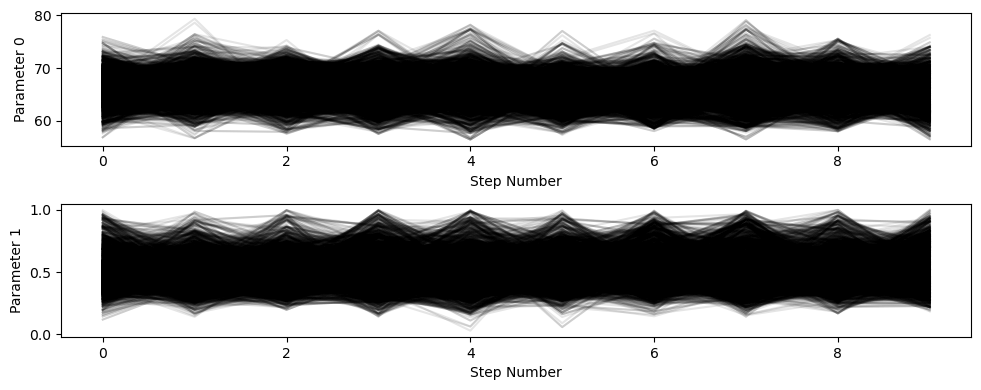

In [13]:
nwalkers, nsteps, ndim = sampler.chain.shape

fig, axes = plt.subplots(ndim, figsize=(10, 2*ndim))

for i in range(ndim):
    axes[i].plot(sampler.chain[:, :, i], color='k', alpha=0.1)
    axes[i].set_ylabel(f'Parameter {i}')
    axes[i].set_xlabel('Step Number')

plt.tight_layout()
plt.show()

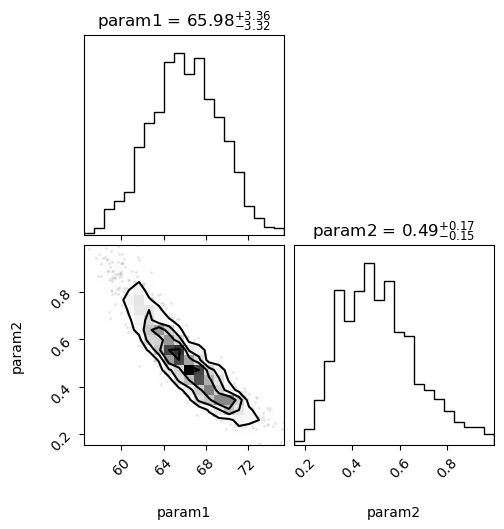

In [14]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

# Create corner plot
fig = corner.corner(flat_samples, labels=["param1", "param2", "param3"], show_titles=True)
plt.show()

In [15]:
tau = sampler.get_autocorr_time()
print(tau)
thin = int(tau[1]+1)

emcee_trace = sampler.get_chain(discard=burn, thin=thin, flat=True).flatten()

[40.6608665  39.44482183]


In [16]:
posterior_mean = np.mean(flat_samples, axis=0)
posterior_mean

array([66.02428686,  0.51319965])

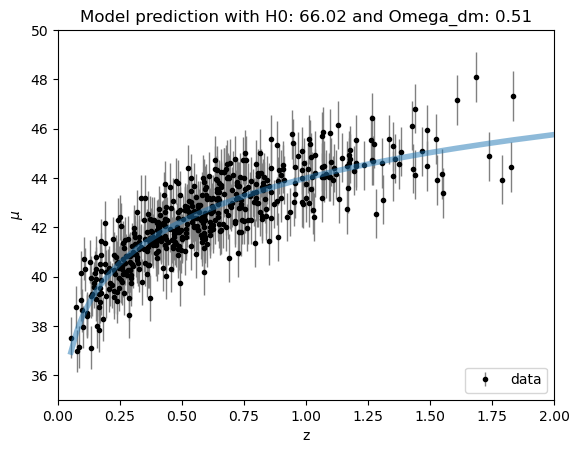

In [17]:
plt.errorbar(z_sample, mu_sample, dmu_sample, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

z_ordered = np.array(sorted(z_sample))

plt.title(f'Model prediction with H0: {posterior_mean[0]:.2f} and Omega_dm: {posterior_mean[1]:.2f}')
plt.plot(z_ordered, model(z_ordered, posterior_mean[0], posterior_mean[1]), zorder=3, linewidth=4, alpha=0.5)

#### Nested Sampling

In [18]:
import dynesty
import dynesty.plotting as dyplot

H0_conv_factor = 3.24078e-20

def dyn_model(z, H0_s, Omega_dm):
    def integrand(x, Omega_dm):
        return 1 / np.sqrt(Omega_dm * (1 + x) ** 3 + (1 - Omega_dm))
    
    vec_integral = np.vectorize(lambda z_val: quad(integrand, 0, z_val, args=(Omega_dm,))[0])
    integral_result = vec_integral(z)
    return 5 * np.log10(((c / H0_s) / (10 * parsec)) * (1 + z) * integral_result)

def dyn_model_loglikelihood(theta, z, mu, dmu):
    H0_s = theta[0] * H0_conv_factor
    Omega_dm = theta[1]

    mu_model = dyn_model(z, H0_s, Omega_dm)
    return -0.5 * np.sum(((mu - mu_model) / dmu) ** 2)

def dyn_prior_transform(theta):
    # u is a unit cube, whose each dimension is in [0, 1]
    return np.array([theta[0] * 20 + 55, theta[1]]) # H0 in [55, 75]

sampler = dynesty.NestedSampler(dyn_model_loglikelihood, dyn_prior_transform, ndim=2, logl_args=(z_sample, mu_sample, dmu_sample))
sampler.run_nested()
sresults = sampler.results

1781it [02:31, 11.78it/s, +500 | bound: 0 | nc: 1 | ncall: 18056 | eff(%): 12.993 | loglstar:   -inf < -234.520 <    inf | logz: -237.232 +/-  0.057 | dlogz:  0.001 >  0.509]


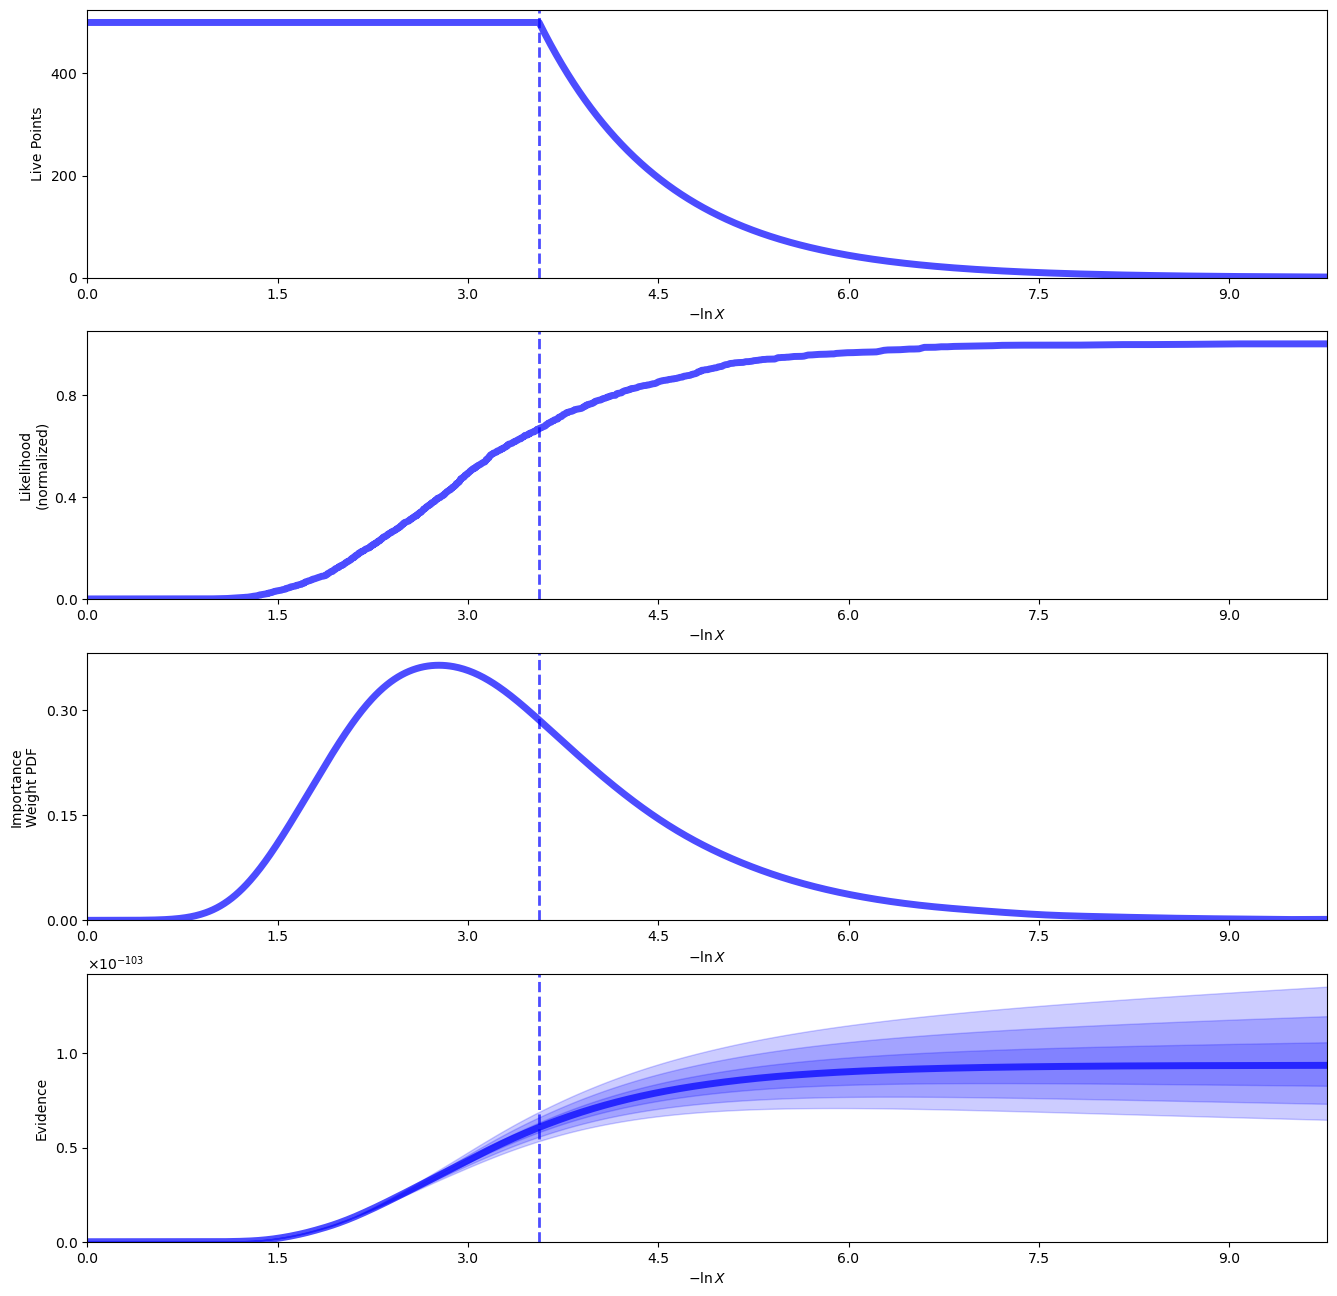

In [19]:
sresults_log_evidence_2d = sresults.logz[-1]
sresults_uncertainty_logz_2d = sresults.logzerr[-1]
rfig, raxes = dyplot.runplot(sresults)

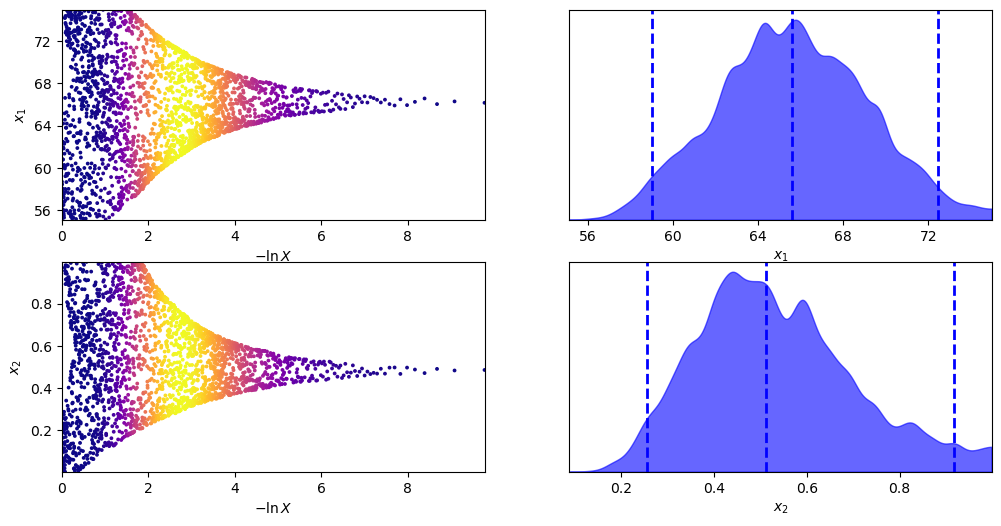

In [20]:
tfig, taxes = dyplot.traceplot(sresults)

In [21]:
samples = sresults.samples
weights = np.exp(sresults.logwt - sresults.logz[-1])

mean = np.average(samples, weights=weights, axis=0)
std = np.sqrt(np.average((samples - mean)**2, weights=weights, axis=0))

print(f'Mean H0: {mean[0]:.2f} ± {std[0]:.2f}')
print(f'Mean Omega_dm: {mean[1]:.2f} ± {std[1]:.2f}')

Mean H0: 65.61 ± 3.46
Mean Omega_dm: 0.53 ± 0.17


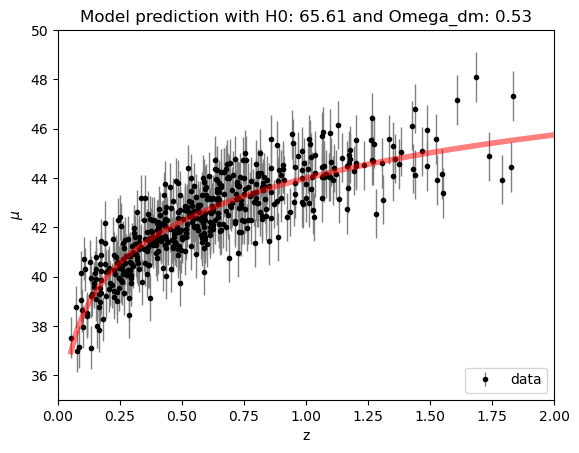

In [22]:
plt.errorbar(z_sample, mu_sample, dmu_sample, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

z_ordered = np.array(sorted(z_sample))

plt.title(f'Model prediction with H0: {mean[0]:.2f} and Omega_dm: {mean[1]:.2f}')
plt.plot(z_ordered, model(z_ordered, mean[0], mean[1]), 'r', zorder=3, linewidth=4, alpha=0.5)

The standard deviation of $H_0$ in the two models are different. In particular, adding as an additional parameter $\Omega_m$ reduces our ability to measure $H_0$. 

In the simpler model:

$\qquad H_0 = 58.31 ± 1.10$

In the second model:

$\qquad H_0 = 65.57 ± 3.46$

From the corner plot we made in the second model, we see a strong correlation between $H_0$ and $\Omega_m$: The form is elongated and diagonal.

### Third Case: Three-parameter model $(H_0, \Omega_\text{DM}, \Omega_\Lambda)$

We do not assume a flat universe anymore. The constraint of Omegas being between 0 and 1 still holds.

In [23]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm, uniform
from scipy.integrate import quad
from scipy.constants import c, parsec

H0_conv_factor = 3.24078e-20
z_sample, mu_sample, dmu_sample = np.loadtxt('data/supernovae.txt').T

# Define prior distributions
H0_prior = norm(loc=70, scale=10)
Omega_dm_prior = uniform()
Omega_lam_prior = uniform()

# Define model
def model(z, theta):
    H0, Omega_dm, Omega_lam = theta
    H0_s = H0 * H0_conv_factor

    def integrand(x, Omega_dm, Omega_lam):
        return 1 / np.sqrt(Omega_dm * (1 + x) ** 3 + (Omega_lam))
    
    vec_integral = np.vectorize(lambda z_val: quad(integrand, 0, z_val, args=(Omega_dm, Omega_lam,))[0])
    integral_result = vec_integral(z)
    return 5 * np.log10(((c / H0_s) / (10 * parsec)) * (1 + z) * integral_result)

def loglikelihood(z, mu, sigma):
    return -0.5 * np.sum(((z - mu) / sigma) ** 2 + np.log(2 * np.pi * sigma**2))

def logprior(theta):
    H0, Omega_dm, Omega_lam = theta
    
    log_H0 = H0_prior.logpdf(H0)
    log_Omega_dm = Omega_dm_prior.logpdf(Omega_dm)
    log_Omega_lam = Omega_lam_prior.logpdf(Omega_lam)

    return log_H0 + log_Omega_dm + log_Omega_lam

def logposterior(theta, z, mu, dmu):
    if not np.isfinite(logprior(theta)):
        return -np.inf
    return logprior(theta) + loglikelihood(model(z, theta), mu, dmu)


In [28]:
ndim = 3
nwalkers = 10
nsteps = 10000
burn = 500
initial_guesses = np.column_stack([
    np.random.normal(70, 0.5, size=nwalkers),
    np.random.uniform(0, 1, size=nwalkers),
    np.random.uniform(0, 1, size=nwalkers)
])

sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=[z_sample, mu_sample, dmu_sample])
sampler.run_mcmc(initial_guesses, nsteps, progress=True)

emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

100%|██████████| 10000/10000 [12:32<00:00, 13.30it/s]


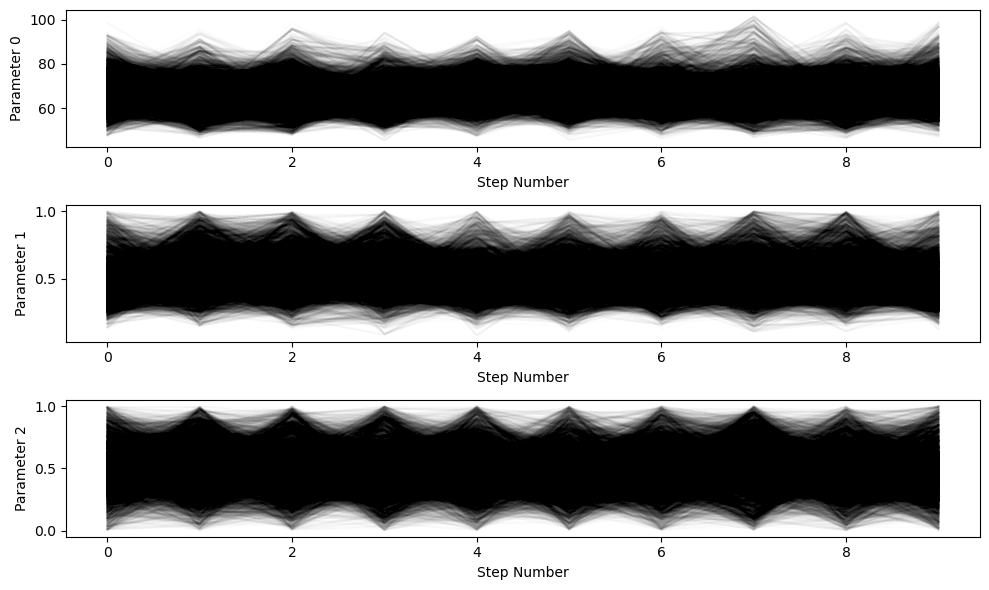

In [29]:
nwalkers, nsteps, ndim = sampler.chain.shape

fig, axes = plt.subplots(ndim, figsize=(10, 2*ndim))

for i in range(ndim):
    axes[i].plot(sampler.chain[:, :, i], color='k', alpha=0.01)
    axes[i].set_ylabel(f'Parameter {i}')
    axes[i].set_xlabel('Step Number')

plt.tight_layout()
plt.show()

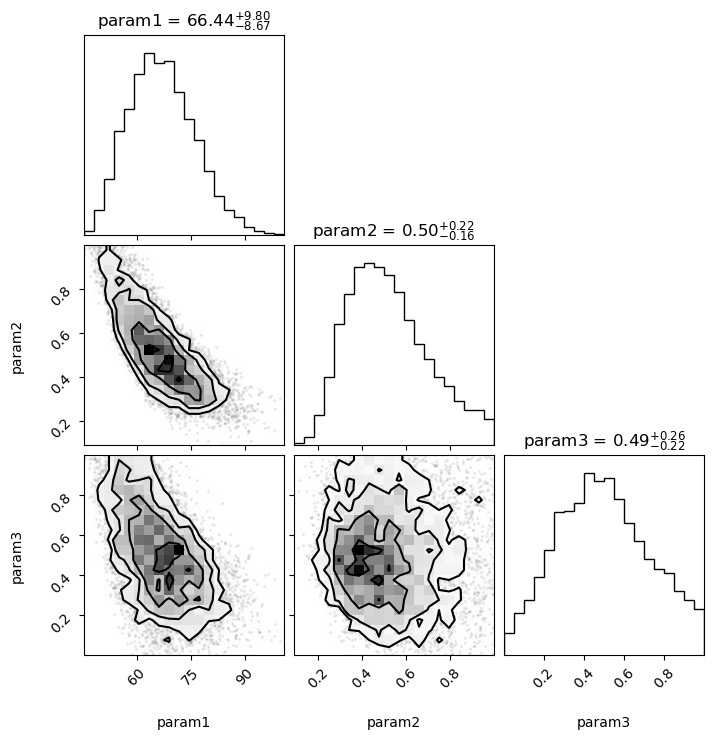

In [30]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

# Create corner plot
fig = corner.corner(flat_samples, labels=["param1", "param2", "param3"], show_titles=True)
plt.show()

In [31]:
tau = sampler.get_autocorr_time()
print(tau)
thin = int(tau[1]+1)

emcee_trace = sampler.get_chain(discard=burn, thin=thin, flat=True).flatten()

[112.30079076 100.75981329  72.7057899 ]


In [32]:
posterior_mean = np.mean(flat_samples, axis=0)
posterior_mean

array([67.00824246,  0.52032507,  0.49939667])

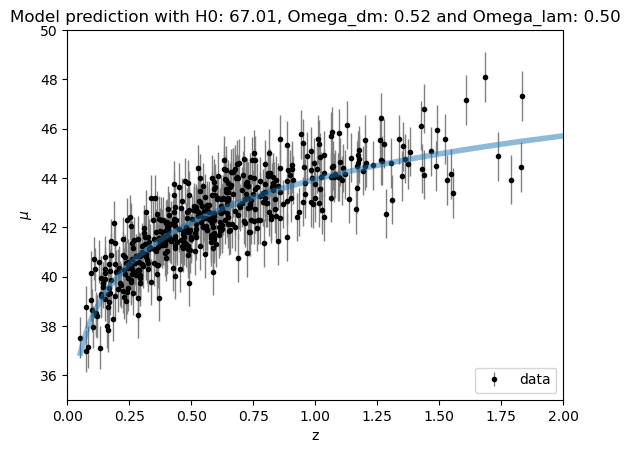

In [33]:
plt.errorbar(z_sample, mu_sample, dmu_sample, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

z_ordered = np.array(sorted(z_sample))

plt.title(f'Model prediction with H0: {posterior_mean[0]:.2f}, Omega_dm: {posterior_mean[1]:.2f} and Omega_lam: {posterior_mean[2]:.2f}')
plt.plot(z_ordered, model(z_ordered, posterior_mean), zorder=3, linewidth=4, alpha=0.5)

In [34]:
import dynesty
import dynesty.plotting as dyplot

H0_conv_factor = 3.24078e-20

def dyn_model(z, theta):
    H0, Omega_dm, Omega_lam = theta
    H0_s = H0 * H0_conv_factor
    def integrand(x, Omega_dm, Omega_lam):
        return 1 / np.sqrt(Omega_dm * (1 + x) ** 3 + (Omega_lam))
    
    vec_integral = np.vectorize(lambda z_val: quad(integrand, 0, z_val, args=(Omega_dm, Omega_lam,))[0])
    integral_result = vec_integral(z)
    return 5 * np.log10(((c / H0_s) / (10 * parsec)) * (1 + z) * integral_result)

def dyn_model_loglikelihood(theta, z, mu, dmu):
    H0 = theta[0]
    Omega_dm = theta[1]
    Omega_lam = theta[2]

    mu_model = dyn_model(z, [H0, Omega_dm, Omega_lam])
    return -0.5 * np.sum(((mu - mu_model) / dmu) ** 2)

def dyn_prior_transform(theta):
    # u is a unit cube, whose each dimension is in [0, 1]
    return np.array([theta[0] * 20 + 55, theta[1], theta[2]]) # H0 in [55, 75]

sampler = dynesty.NestedSampler(dyn_model_loglikelihood, dyn_prior_transform, ndim=3, logl_args=(z_sample, mu_sample, dmu_sample))
sampler.run_nested()
sresults = sampler.results

1944it [02:23, 13.51it/s, +500 | bound: 1 | nc: 1 | ncall: 18128 | eff(%): 13.864 | loglstar:   -inf < -234.519 <    inf | logz: -237.557 +/-  0.061 | dlogz:  0.001 >  0.509]


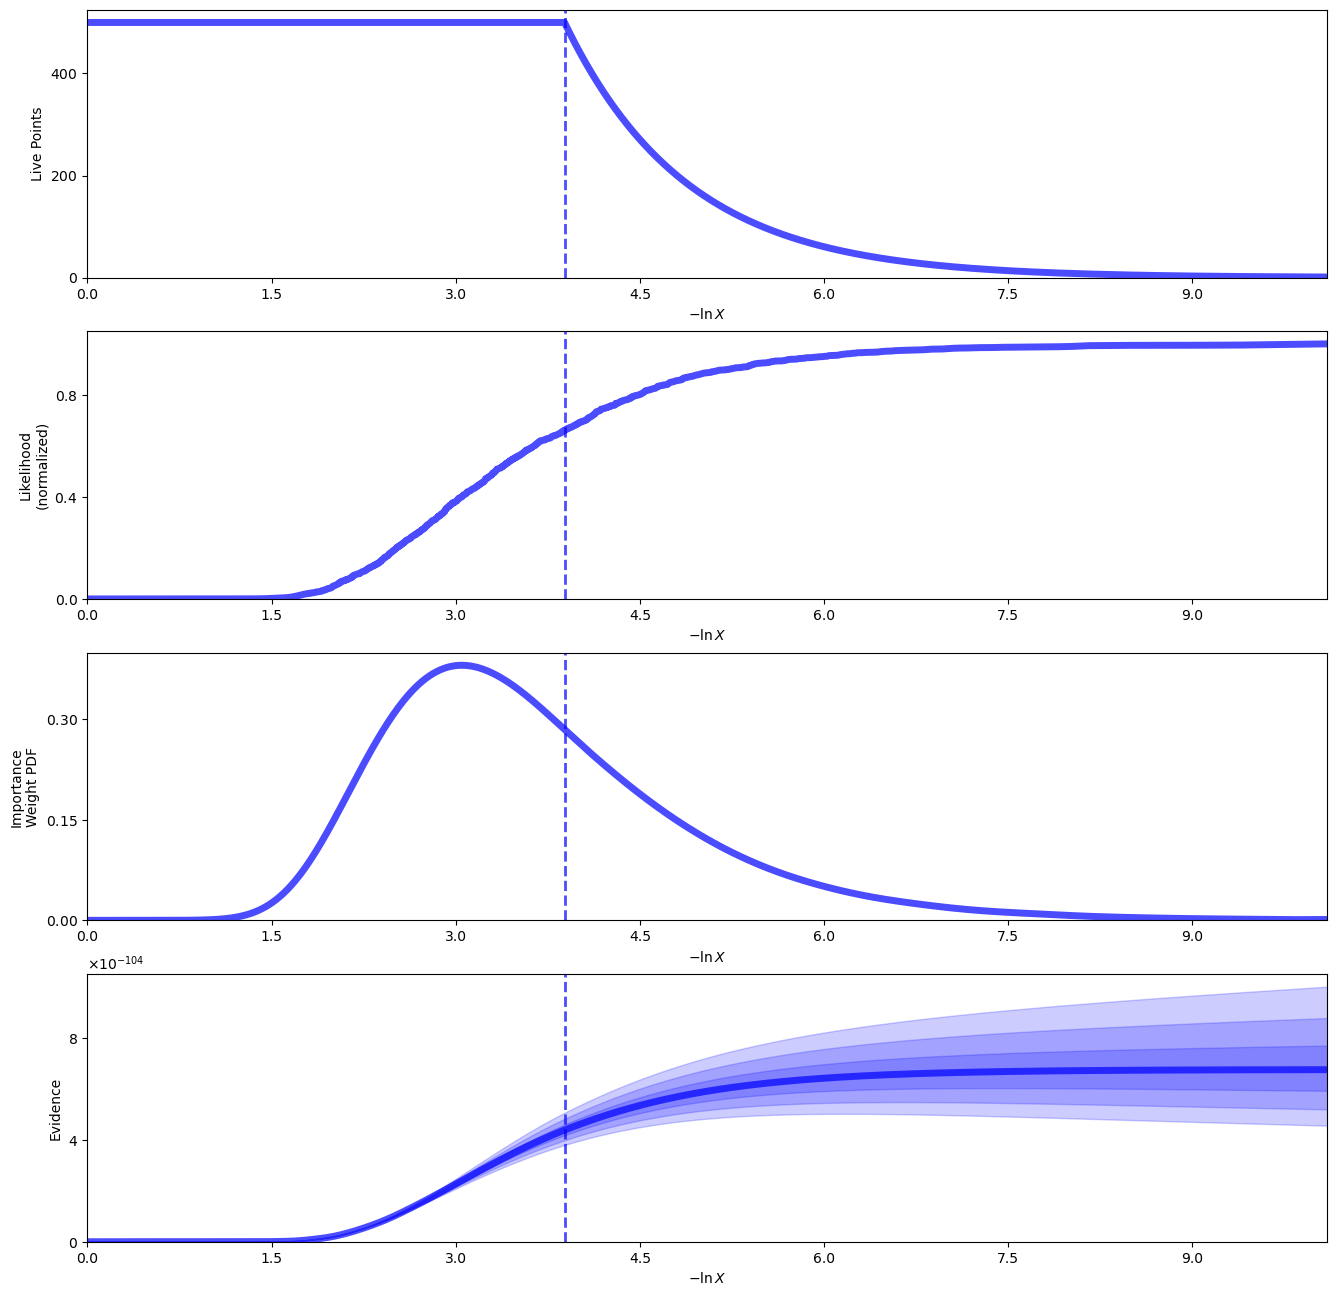

In [35]:
sresults_log_evidence_3d = sresults.logz[-1]
sresults_uncertainty_logz_3d = sresults.logzerr[-1]
rfig, raxes = dyplot.runplot(sresults)

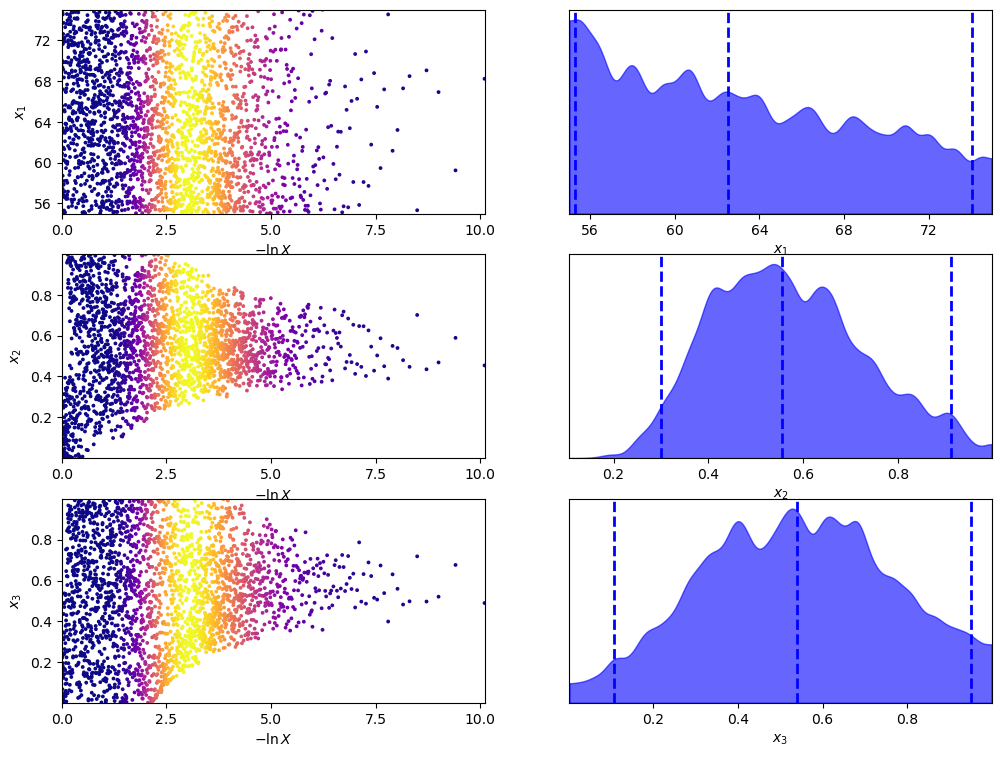

In [36]:
tfig, taxes = dyplot.traceplot(sresults)

In [37]:
samples = sresults.samples
weights = np.exp(sresults.logwt - sresults.logz[-1])

mean = np.average(samples, weights=weights, axis=0)
std = np.sqrt(np.average((samples - mean)**2, weights=weights, axis=0))

print(f'Mean H0: {mean[0]:.2f} ± {std[0]:.2f}')
print(f'Mean Omega_dm: {mean[1]:.2f} ± {std[1]:.2f}')
print(f'Mean Omega_lam: {mean[2]:.2f} ± {std[2]:.2f}')

Mean H0: 63.27 ± 5.62
Mean Omega_dm: 0.57 ± 0.16
Mean Omega_lam: 0.54 ± 0.22


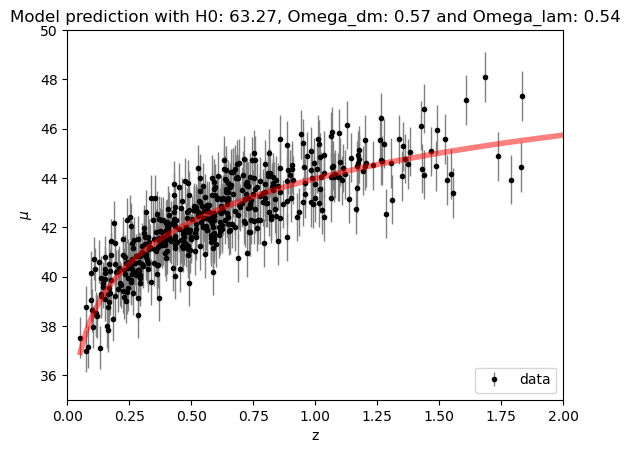

In [38]:
plt.errorbar(z_sample, mu_sample, dmu_sample, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

z_ordered = np.array(sorted(z_sample))

plt.title(f'Model prediction with H0: {mean[0]:.2f}, Omega_dm: {mean[1]:.2f} and Omega_lam: {mean[2]:.2f}')
plt.plot(z_ordered, model(z_ordered, mean), 'r', zorder=3, linewidth=4, alpha=0.5)

### Bayes Factor

Thanks to `dynesty`, we have our log-Bayes factor already computed for us. All it takes is to apply the exponential function to the differences of log-BFs.

In [39]:
bayes_factor_2d1d = np.exp(sresults_log_evidence_2d - sresults_log_evidence_1d)
bayes_factor_3d2d = np.exp(sresults_log_evidence_3d - sresults_log_evidence_2d)
bayes_factor_3d1d = np.exp(sresults_log_evidence_3d - sresults_log_evidence_1d)

print(f'Bayes factor 2D vs 1D: {bayes_factor_2d1d:.2f}')
print(f'Bayes factor 3D vs 2D: {bayes_factor_3d2d:.2f}')
print(f'Bayes factor 3D vs 1D: {bayes_factor_3d1d:.2f}')

Bayes factor 2D vs 1D: 5.93
Bayes factor 3D vs 2D: 0.72
Bayes factor 3D vs 1D: 4.28


There's a strong evidence in favor of the second model against the first one. 

There's not a big difference between third and second models. This means that the second model is preferred, as the increase in complexity does NOT justify the little increase in the fit.

Finally, we favor third model against the first model.

---

In summary:

We prefer the second model. The Bayes factor 2D vs 1D goes well beyond 4.6, and the Bayes factor between 3D and 2D indicates a negligible gain.

This also means that given this set of data, the Bayes factor that dark energy exists (3D) is 0.72, which suggests poor support for it. 

# Part 2: Synthetic data - Sampling

The request is to obtain a dataset that is 10 times larger than the original one, by upsampling.

`astroML` library's `EmpiricalDistribution` works only for 1D, so we opt for a `KernelDensity` approach.

In [ ]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

z_sample, mu_sample, dmu = np.loadtxt('data/supernovae.txt').T

X = np.array([z_sample, mu_sample]).T
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X)
X_upsampled = kde.sample(X.shape[0] * 10)

(5000, 2)

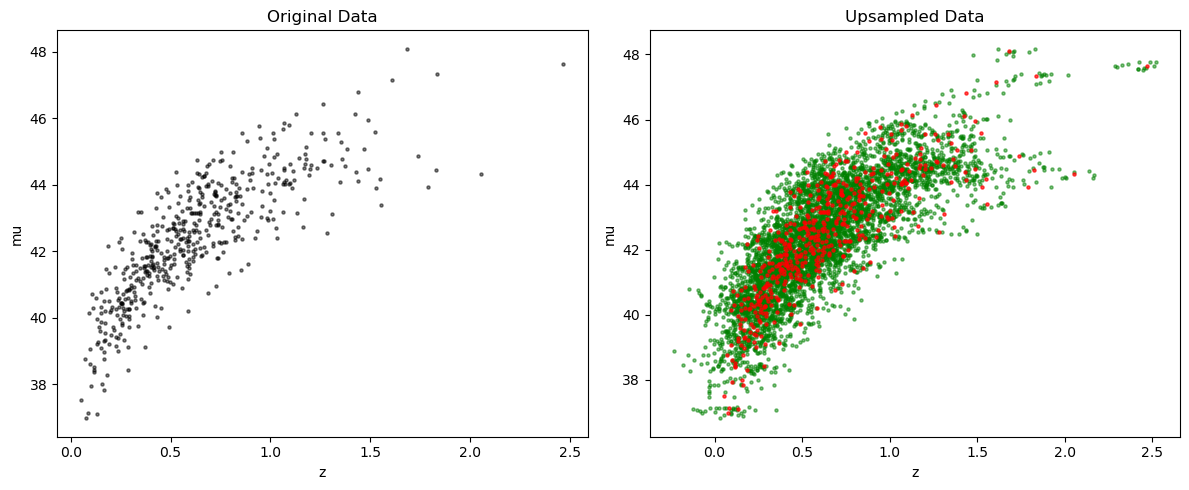

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(X[:, 0], X[:, 1], c='k', s=5, alpha=0.5)
ax[0].set_xlabel('z')
ax[0].set_ylabel('mu')
ax[0].set_title('Original Data')

ax[1].scatter(X_upsampled[:, 0], X_upsampled[:, 1], c='g', s=5, alpha=0.5)
ax[1].scatter(X[:, 0], X[:, 1], c='r', s=5, alpha=0.7)
ax[1].set_xlabel('z')
ax[1].set_ylabel('mu')
ax[1].set_title('Upsampled Data')
plt.tight_layout()
plt.show()

# Part 3: Deep Learning Approach

The main task now is not to find the best parameter for estimating $\mu$. We instead fit a neural network that can estimate it for us. Sadly, we won't really know what goes under the hood.

We opt for a MLP based architecture. It is a simple and efficient global approximator.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.hidden = nn.ModuleList()
        last_size = input_size
        for size in hidden_sizes:
            self.hidden.append(nn.Linear(last_size, size))
            last_size = size
        self.output = nn.Linear(last_size, output_size)
    
    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        x = self.output(x)
        return x

In [ ]:
model1 = MLP(input_size=1, hidden_sizes=[128, 64, 32, 16], output_size=1)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_train = torch.tensor(X, dtype=torch.float32)[:, 0].unsqueeze(1)
y_train = torch.tensor(X, dtype=torch.float32)[:, 1].unsqueeze(1)

num_epochs = 10000
for epoch in range(num_epochs):
    model1.train()
    optimizer.zero_grad()
    
    outputs = model1(X_train)
    loss = criterion(outputs, y_train)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/10000], Loss: 20.3253
Epoch [200/10000], Loss: 4.0049
Epoch [300/10000], Loss: 2.2707
Epoch [400/10000], Loss: 1.3783
Epoch [500/10000], Loss: 1.0542
Epoch [600/10000], Loss: 0.9672
Epoch [700/10000], Loss: 0.9278
Epoch [800/10000], Loss: 0.8960
Epoch [900/10000], Loss: 0.8769
Epoch [1000/10000], Loss: 0.8682
Epoch [1100/10000], Loss: 0.8617
Epoch [1200/10000], Loss: 0.8568
Epoch [1300/10000], Loss: 0.8528
Epoch [1400/10000], Loss: 0.8498
Epoch [1500/10000], Loss: 0.8474
Epoch [1600/10000], Loss: 0.8454
Epoch [1700/10000], Loss: 0.8436
Epoch [1800/10000], Loss: 0.8421
Epoch [1900/10000], Loss: 0.8408
Epoch [2000/10000], Loss: 0.8396
Epoch [2100/10000], Loss: 0.8385
Epoch [2200/10000], Loss: 0.8376
Epoch [2300/10000], Loss: 0.8367
Epoch [2400/10000], Loss: 0.8359
Epoch [2500/10000], Loss: 0.8353
Epoch [2600/10000], Loss: 0.8349
Epoch [2700/10000], Loss: 0.8345
Epoch [2800/10000], Loss: 0.8341
Epoch [2900/10000], Loss: 0.8338
Epoch [3000/10000], Loss: 0.8335
Epoch [3100/10000]

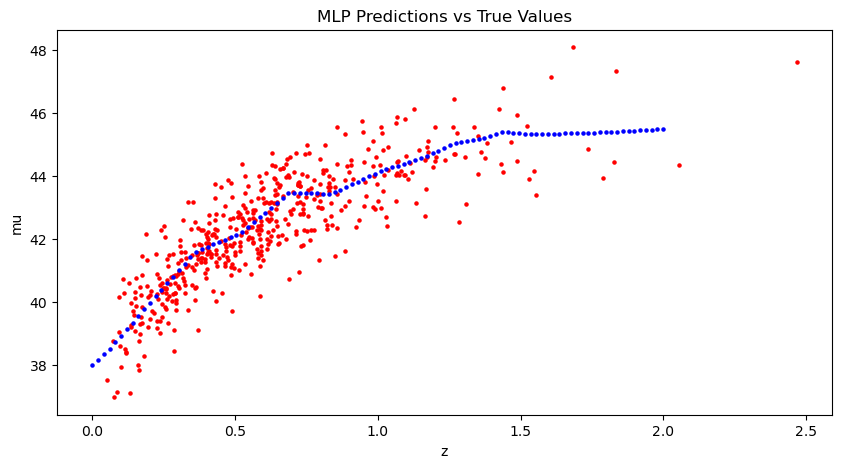

In [ ]:
model1.eval()

with torch.no_grad():
    X_test = torch.Tensor(np.linspace(0, 2, 100).reshape(-1, 1))
    y_pred = model1(X_test).numpy()

plt.figure(figsize=(10, 5))
plt.scatter(X_test.numpy(), y_pred, c='b', s=5, label='Predicted', zorder=2)
plt.scatter(X[:, 0], X[:, 1], c='r', s=5, label='True')
plt.xlabel('z')
plt.ylabel('mu')
plt.title('MLP Predictions vs True Values (original data)')
plt.show()

In [46]:
model2 = MLP(input_size=1, hidden_sizes=[128, 64, 32, 16], output_size=1)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_train = torch.tensor(X_upsampled, dtype=torch.float32)[:, 0].unsqueeze(1)
y_train = torch.tensor(X_upsampled, dtype=torch.float32)[:, 1].unsqueeze(1)

num_epochs = 10000
for epoch in range(num_epochs):
    model2.train()
    optimizer.zero_grad()
    
    outputs = model2(X_train)
    loss = criterion(outputs, y_train)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 22.1396
Epoch [200/10000], Loss: 3.0234
Epoch [300/10000], Loss: 1.6662
Epoch [400/10000], Loss: 1.2699
Epoch [500/10000], Loss: 1.1476
Epoch [600/10000], Loss: 1.1250
Epoch [700/10000], Loss: 1.1180
Epoch [800/10000], Loss: 1.1136
Epoch [900/10000], Loss: 1.1104
Epoch [1000/10000], Loss: 1.1079
Epoch [1100/10000], Loss: 1.1060
Epoch [1200/10000], Loss: 1.1045
Epoch [1300/10000], Loss: 1.1033
Epoch [1400/10000], Loss: 1.1021
Epoch [1500/10000], Loss: 1.1009
Epoch [1600/10000], Loss: 1.0999
Epoch [1700/10000], Loss: 1.0992
Epoch [1800/10000], Loss: 1.0987
Epoch [1900/10000], Loss: 1.0982
Epoch [2000/10000], Loss: 1.0975
Epoch [2100/10000], Loss: 1.0967
Epoch [2200/10000], Loss: 1.0960
Epoch [2300/10000], Loss: 1.0956
Epoch [2400/10000], Loss: 1.0954
Epoch [2500/10000], Loss: 1.0954
Epoch [2600/10000], Loss: 1.0953
Epoch [2700/10000], Loss: 1.0952
Epoch [2800/10000], Loss: 1.0952
Epoch [2900/10000], Loss: 1.0951
Epoch [3000/10000], Loss: 1.0951
Epoch [3100/10000]

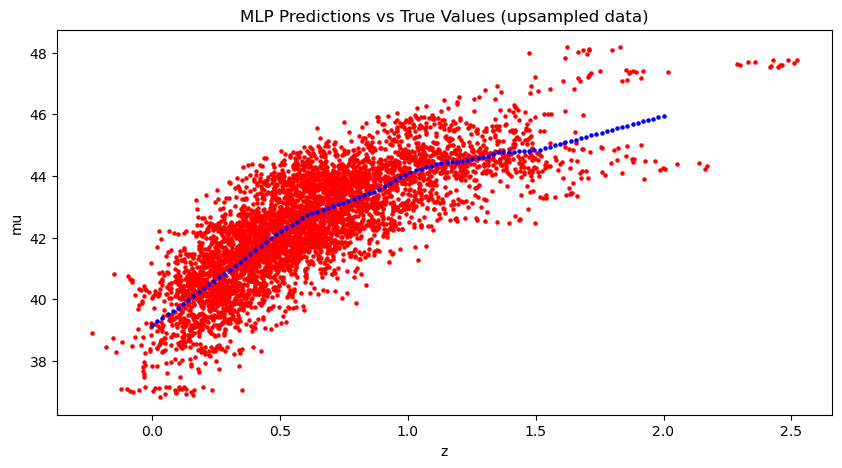

In [47]:
model2.eval()
with torch.no_grad():
    X_test = torch.Tensor(np.linspace(0, 2, 100).reshape(-1, 1))
    y_pred = model2(X_test).numpy()

plt.figure(figsize=(10, 5))
plt.scatter(X_test.numpy(), y_pred, c='b', s=5, label='Predicted', zorder=2)
plt.scatter(X_upsampled[:, 0], X_upsampled[:, 1], c='r', s=5, label='True')
plt.xlabel('z')
plt.ylabel('mu')
plt.title('MLP Predictions vs True Values (upsampled data)')
plt.show()

### Bayesian statistics: Pros and Cons

Bayesian statistics is a powerful tool, revolved around the update probabilities in the Bayes theorem as new data comes in. Consequentially, we can incorporate prior knowledge into our model, which can be very useful when dealing with scarse data. One thing that I noticed during the course is the size of observations in our data, which is way more limited than that required in a, let's say, neural network model. Another difference is that a Bayesian approach gives us full probability distributions for our parameters, called the posterior. This makes the model more interpretable, and we can make the needed analysis on a specific distribution.

But, there's always a price to pay for these features. One of the most used techniques, MCMC, can be quite slow for complex posteriors. The chain may have difficulty in exploring the parameter space for many reasons, which can be complex model, bad priors, bad hyperparameters, and each step in the algorithm might not produce a similar number of "effective" steps. So, choosing the prior becomes a very important step that can make or break the model in finding the posterior distribution of the paramaters. Lastly, `PyMC`, the library I wished to use for all the lectures but failed to do so at the very last notebook, has a very steep learning curve. It is very powerful, but also quite frustrating at times. 

Given scarse data, and/or known prior knowledge, a Bayesian approach will be quite effective, even more so than a Frequentist approach.

